<a href="https://colab.research.google.com/github/lucavauda/makemore-karpathys-lecture/blob/main/makemore3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# makemore: part 3

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
# print the first 8 elements
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
## print the lenght of the file
len(words)

32033

In [ ]:
# build the vocabulary of charactres and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset
def build_dataset(words):
  block_size = 3
  X,Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X,Y

# splitting random words into traning, dev and test set
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# MLP revised
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g) # increase from 2 dim embeddings to 10 dimensional embeddings
# W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2 # of course the first 6 becomes 30 (3*10)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5) # kaiming init
# b1 = torch.randn(n_hidden, generator=g) * 0.01 at the end, we don't want to use this bias, we use the batch normalization bias, no need to use this
W2 = torch.randn((n_hidden, 27), generator=g) * 0.01
# you don't want to set w2 at zero
b2 = torch.randn(27, generator=g) * 0 # b2 set to 0 at initialization

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden)) # these are not trained with backprop but with a simpler optimization function
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngains, bnbias]

print(sum(p.nelement() for p in parameters)) # numbers of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 30
lossi = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # hpreact = bngains * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # batch normalization
  # BatchNorm layer
  # -----------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngains * (hpreact - bnmeani) / bnstdi + bnbias

  # we are going to keep a running mean and std during training
  with torch.no_grad(): # outside and on the side of the gradient based optimization
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -----------------
  # Non-Linearity (tanh), for deeper network, empirically reLU works better
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update - modify with a learning rate
  #lr = lrs[i]
  lr = 0.1 if i < 10000 else 0.01
  # we can use the learn decay loss
  # modify for the last step of the training the learning rate to be 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  if i % 10000 == 0: # print once in a while
    print(f'{i:7d}/{max_steps:7d}:{loss.item():4f}')
  lossi.append(loss.log10().item())


      0/ 200000:3.319774
  10000/ 200000:2.497976
  20000/ 200000:2.340629
  30000/ 200000:2.329052
  40000/ 200000:1.676216
  50000/ 200000:2.089127
  60000/ 200000:1.663130
  70000/ 200000:2.193901
  80000/ 200000:2.564897
  90000/ 200000:2.372077
 100000/ 200000:2.113152
 110000/ 200000:2.063868
 120000/ 200000:2.084643
 130000/ 200000:1.965992
 140000/ 200000:2.162648
 150000/ 200000:2.270882
 160000/ 200000:2.154498
 170000/ 200000:1.932925
 180000/ 200000:2.113736
 190000/ 200000:2.164387


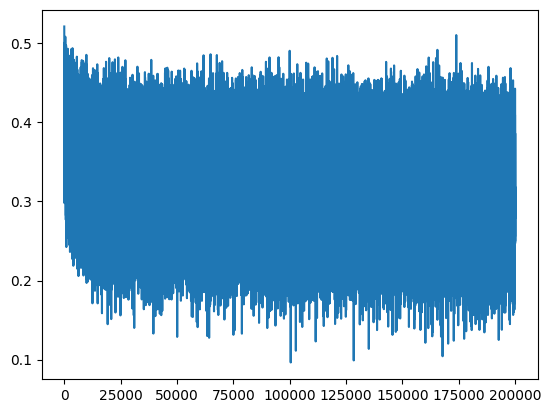

In [ ]:
plt.plot(lossi)

[Documentation for no_grad](https://pytorch.org/docs/stable/generated/torch.no_grad.html), is used because whatever happens in this function is requiered by Torch to never require any gradient.

In [ ]:
# calibrate the batch norm at the end of training

with torch.no_grad(): # none of this will be done on the backward pass
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim= True)
  bnstd = hpreact.std(0, keepdim=True)

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
      'train': (Xtr,Ytr),
      'val' : (Xdev, Ydev),
      'test' : (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  # hpreact = bngains * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # batch normalization
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # at test time, we are going to fix this, clump them and use them at inference time
  # the benefit that we've gained is that we can forward a single example, because the mean and std are fixed tensor
  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0820887088775635
val 2.1236214637756348


# Sample from the model

In [ ]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mria.
mayah.
seel.
nihah.
lore.
mastendrlee.
aderedielin.
shy.
jen.
edenslan.
nar.
katelmalyan.
noshir.
rilairiel.
kindo.
jelionnicoory.
brey.
dariyah.
faehs.
kaysh.


# Fixing initial loss

So, after presenting the code from the last part (makemore: part 2), with some refactoring of the code, the first thing we notice is how the network is *improperly configured in the initialization*.  At first, we can notice how the first 0-1000 iteration have a loss of (circa) 27.88. This number rapidly comes down to less than 2. But 27 is way to high.
Consider this problem, at inizialition there are 27 character that could come one after another. At initialization, we have no reason to believe any characters to be much more likely than others. We expect that the probability distribution initially is a uniform distribution, assigning each character the same probability.

Roughly, 1/27 would be the idea initial probability:

In [ ]:
torch.tensor(1/27.0)

tensor(0.0370)

Then you have to calculate the loss, based on the negative log probability.

In [ ]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

The actual results we should expect at initialization is circa `3.92`.

In [ ]:
# 4-dimensional example of the issue
#logits = torch.tensor([-3.0, 5.0, 0.0, 2.0]) # the loss is high
logits = torch.rand(4) # the distribution is uniform
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.2738, 0.2462, 0.1825, 0.2975]), tensor(1.7007))

By fixing the initialization bias and weights, we get a less steeper loss.
We multiplied by 0 the bias and by 0.01 the weights.
Infact, when we plot it, we do not see the "hockey stick" graph. We can notice how the logits are squashed and the network is doing the "heavy work".
Also, we are getting a little improvment on the loss. This is because we are spending more time optimizing the network and we are not wasting the first cycles "squashing down" the weights.

# fixing the saturated tanh

The `tanh` function is a squashing function. It takes arbitrary number and squashes any number between -1 and 1. We can notice by printing `h` that many of them are just -1 or 1. This problem is the **tanh saturation**.

To visualize this, you convert the tensor into a list of value of floating numbers and then plotting them.

In [ ]:
h

tensor([[-1.0000,  0.9437, -0.4301,  ...,  0.8613,  1.0000,  1.0000],
        [ 0.7976, -0.5923, -0.8230,  ..., -1.0000,  1.0000,  1.0000],
        [ 0.9999, -1.0000, -0.9517,  ..., -1.0000,  1.0000,  0.2204],
        ...,
        [-0.8278,  1.0000,  0.9820,  ..., -0.9922,  0.9903,  1.0000],
        [ 0.9998, -0.9990, -1.0000,  ..., -1.0000,  1.0000,  1.0000],
        [-0.9562,  0.9984, -0.9991,  ...,  0.8151,  0.9981,  0.3243]],
       grad_fn=<TanhBackward0>)

In [ ]:
h.shape

torch.Size([30, 200])

In [ ]:
h.view(-1).shape

torch.Size([6000])

(array([535., 167., 168., 162., 117., 103., 121., 116., 116.,  93.,  97.,
        106.,  70.,  97.,  71.,  88.,  57.,  75.,  85., 100.,  78.,  98.,
         87.,  91.,  80., 105., 103.,  91.,  79., 103.,  81.,  86.,  82.,
         89.,  75.,  82.,  95.,  84.,  89.,  82.,  86.,  79., 113., 121.,
        111., 119., 130., 168., 185., 584.]),
 array([-9.99998510e-01, -9.59998543e-01, -9.19998577e-01, -8.79998610e-01,
        -8.39998643e-01, -7.99998677e-01, -7.59998710e-01, -7.19998744e-01,
        -6.79998777e-01, -6.39998810e-01, -5.99998844e-01, -5.59998877e-01,
        -5.19998910e-01, -4.79998944e-01, -4.39998977e-01, -3.99999011e-01,
        -3.59999044e-01, -3.19999077e-01, -2.79999111e-01, -2.39999144e-01,
        -1.99999177e-01, -1.59999211e-01, -1.19999244e-01, -7.99992776e-02,
        -3.99993110e-02,  6.55651092e-07,  4.00006223e-02,  8.00005889e-02,
         1.20000556e-01,  1.60000522e-01,  2.00000489e-01,  2.40000455e-01,
         2.80000422e-01,  3.20000389e-01,  3.60000

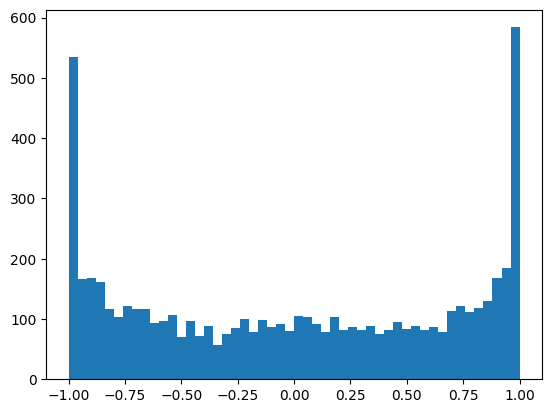

In [ ]:
plt.hist(h.view(-1).tolist(), 50) # the tolist() function converst the tensor
                                  # a list of float

You can also visualize the pre-activation.

(array([  1.,   0.,   2.,   3.,   2.,   6.,  12.,  13.,  13.,  19.,  36.,
         36.,  42.,  62.,  75., 119., 123., 150., 282., 303., 457., 495.,
        640., 681., 526., 420., 381., 252., 170., 165., 133.,  85.,  74.,
         53.,  41.,  38.,  21.,  13.,  13.,  14.,   8.,   4.,   2.,   2.,
          4.,   3.,   2.,   1.,   1.,   2.]),
 array([-7.04710531, -6.74283566, -6.43856602, -6.13429637, -5.83002672,
        -5.52575707, -5.22148743, -4.91721778, -4.61294813, -4.30867848,
        -4.00440884, -3.70013919, -3.39586954, -3.09159989, -2.78733025,
        -2.4830606 , -2.17879095, -1.8745213 , -1.57025166, -1.26598201,
        -0.96171236, -0.65744271, -0.35317307, -0.04890342,  0.25536623,
         0.55963588,  0.86390553,  1.16817517,  1.47244482,  1.77671447,
         2.08098412,  2.38525376,  2.68952341,  2.99379306,  3.29806271,
         3.60233235,  3.906602  ,  4.21087165,  4.5151413 ,  4.81941094,
         5.12368059,  5.42795024,  5.73221989,  6.03648953,  6.34075918,
 

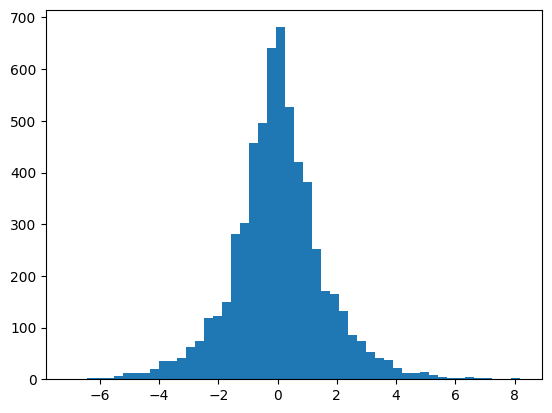

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50)

The distribution is very broad, from -15 to 15.

But why is it a problem? When doing backpropagation, we are doing backward pass starting at the loss and flowing through the netowork backwards. In particular, through the `torch.tanh`. This layer is made up of 200 neurons for each one of these examples and implements an **element-wise tanh**.

Doing the chan-rule of backprop, you calculate the derivative of tanh, `gradient = (1 - t**2) * gradient`. But what if you get your output to 1 or -1? No matter what the gradient is, you will get the gradient equal to zero.

Intuitively, think about how tanh function works when we have -1 o 1, we are on the tail of the curve. So changing the input, will not change that much because we are in the flat region of tanh, so there will be no **impact on the loss**.

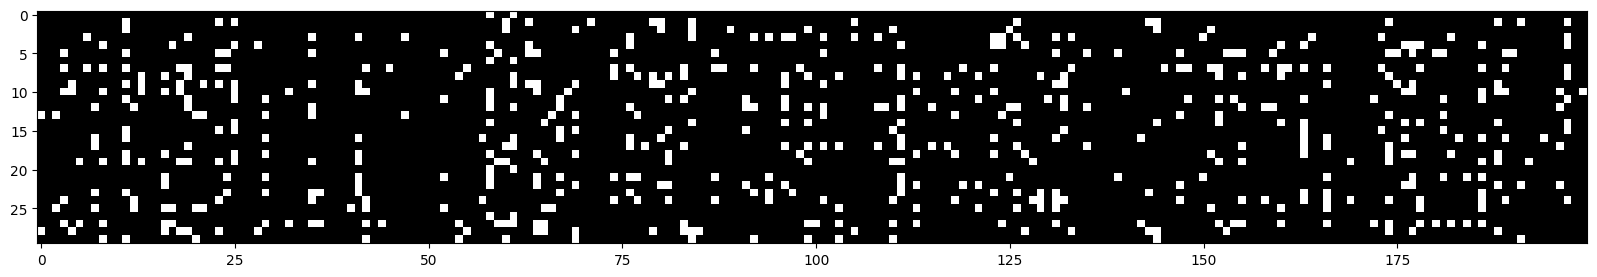

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

How often `h` is in a flat region? We can visualize it by using `h.abs() > 0.99` as a Boolean tensor, where white is true and black is false. 32 examples and 200 neurons. A lot of them are white, so in a flat tails. The backward gradient is destroyed.

**Dead neuron**: when no single example in the 32 column does not activate. No matter what input, the neuron fires all 1 or -1.

This could happen also to sigmoid and ReLU.

Leaky ReLU doesn't suffer from this, neither does ELU.

The hpreact is too large, it's creating a saturated tanh. It means there's less training because they update it less frequently.

How to fix it? We can multiply by `0.01` the `b1` bias vector, to keep a bit of variance and entropy; and multiply the `0.1` the `W1` weight matrix.

Now, let's look on how the plot of h have changed. The histogram, at first was with very high value at the extreme now it is much more distributed. Then, the distribution is now black with no white. No neurons are saturated in either direction.

# calculating the init scale: "Kaiming init"

No one actually set the aforementioned parameters by hand.

In [ ]:
x = torch.randn(1000, 10) # guassian distribution
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std()) # the mean is the same, but the amplitude of the curve is greater, hence the standard deviation is greater
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt-subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

This is basically what's happening in the network. Our objective is to have relatively similar activation. Preserving the distribution to remain a gaussian. Intuitvely, by multipling by `5` the `w`, the amplitude grows. But if we multiply by `0.2`, it shrink. What do I multiply to excatly preserve the distribution? Mathematically, you are supposed to divide by the square root of the **fan-in**. The fan-in is the number of the input (10). So here we should divide by `sqrt(10)`, or `/ 10**0.5`.

Kaiming He et al. has a really interesting paper about it. Karpathy points out that the main point of this paper is that you should initialize the weight by having a gaussian distribution having a standard deviation of `sqrt(2/fan-in)`. The 2 is because in the paper ReLU is analyzed. Instead, for the backpropagation, they found out that if the forward pass is well-initialized, the backward pass will approximately initialized up to a costant factor that has to do with the size of hidden neuron in early and late neurons.
If we go to the [torch.init.nn documentation](https://pytorch.org/docs/stable/nn.init.html), we can se Kaiming normal, which is the standard way to initialize networks.
Now with modern frameworks, a lot of things are integrated better, for example like residual connection, the use of normalization layers and much better optimizer (like RMSProp and Adam).

In [ ]:
(torch.randn(1000) * 0.2).std() # the standard deviation is the factor we multiply by

So, in the initialization, we want to multiply by 5/3 (which is standard for the tanh activaction function [see documentation]) dived sqrt(fan-in) [30].

In [ ]:
(5/3) / (30**0.5) #0.3

# batch normalization

`hpreact` are hidden state, we don't want it to be too small and too large. We want them to be roughly gaussian. Just normalize them to be gaussian. Standardizing to gaussian is a differentiable operation.

In [ ]:
 hpreact.shape() #32, 200

In [ ]:
hpreact.mean(0, keepdim=True).shape #1, 200

In [ ]:
hpreact.std(0, keepdim=True).shape #1, 200

In the main training script, we can make the batch normalization code is  `hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) # batch normalization`. But it will not increase the performance just yet, we want it to be roughly gaussian only at the initialization. We would like to be able to move the distribution around.
# Scale and shift
scaling and adding a bias in the initialization. After initializing two tensors:

*   `bngain = torch.ones((1, n_hidden))`
*   `bnbias = torch.zeros((1, n_hidden))`

We first multply at the start by `bngain` and at the end add `bnbias`.
At initialization will be a nice gaussian, coming out will be unit gaussian for each neuron. During backprop, the network will be able to scale and shift the distribution.

Also, include them in the parameters of the neural net.

Batch normalization could be a kind of data augmentation because of the padding of the data with entropy. Now there are some other regularization techniques, but batch norm is usally used. Yet, it can lead to some weird results.

